In [ ]:
import pandas as pd
from pandas import set_option
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [ ]:
import io
data = pd.read_csv('/content/drive/MyDrive/SCDB_Legacy_01_justiceCentered_Citation.csv',encoding = "ISO-8859-1")


<ipython-input-95-d20ba231a056>:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/SCDB_Legacy_01_justiceCentered_Citation.csv',encoding = "ISO-8859-1")


In [ ]:
data.head(5) # dataset view

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,...,majVotes,minVotes,justice,justiceName,vote,opinion,direction,majority,firstAgreement,secondAgreement
0,1791-001,1791-001-01,1791-001-01-01,1791-001-01-01-01-01,8/3/1791,6.0,2 U.S. 401,NaN,1 L. Ed. 433,1791 U.S. LEXIS 189,...,5.0,0.0,1,JJay,1.0,1.0,1.0,2.0,NaN,NaN
1,1791-001,1791-001-01,1791-001-01-01,1791-001-01-01-01-02,8/3/1791,6.0,2 U.S. 401,NaN,1 L. Ed. 433,1791 U.S. LEXIS 189,...,5.0,0.0,3,WCushing,1.0,1.0,1.0,2.0,NaN,NaN
2,1791-001,1791-001-01,1791-001-01-01,1791-001-01-01-01-03,8/3/1791,6.0,2 U.S. 401,NaN,1 L. Ed. 433,1791 U.S. LEXIS 189,...,5.0,0.0,4,JWilson,1.0,1.0,1.0,2.0,NaN,NaN
3,1791-001,1791-001-01,1791-001-01-01,1791-001-01-01-01-04,8/3/1791,6.0,2 U.S. 401,NaN,1 L. Ed. 433,1791 U.S. LEXIS 189,...,5.0,0.0,5,JBlair,1.0,1.0,1.0,2.0,NaN,NaN
4,1791-001,1791-001-01,1791-001-01-01,1791-001-01-01-01-05,8/3/1791,6.0,2 U.S. 401,NaN,1 L. Ed. 433,1791 U.S. LEXIS 189,...,5.0,0.0,6,JIredell,1.0,1.0,1.0,2.0,NaN,NaN


In [ ]:
data.shape # shape of the data frame

(249793, 61)

In [ ]:
SCDB_OUTCOME_MAP=None
def get_outcome_map():
    """
    Get the outcome map to convert an SCDB outcome into
    an affirm/reverse/other mapping.

    Rows correspond to vote types.  Columns correspond to disposition types.
    Element values correspond to:
    * -1: no precedential issued opinion or uncodable, i.e., DIGs
    * 0: affirm, i.e., no change in precedent
    * 1: reverse, i.e., change in precent
    """

    # Create map; see appendix of paper for further documentation
    outcome_map = pd.DataFrame([[-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, 0, 0, 0, -1, 0, -1, -1, -1, -1, -1]])
    outcome_map.columns = range(1, 12)
    outcome_map.index = range(1, 9)

    return outcome_map
def get_outcome(vote, disposition, outcome_map=SCDB_OUTCOME_MAP):
    """
    Return the outcome code based on outcome map.
    """
    if not outcome_map:
        SCDB_OUTCOME_MAP=get_outcome_map()
        outcome_map = SCDB_OUTCOME_MAP

    if pd.isnull(vote) or pd.isnull(disposition):
        return -1

    return outcome_map.loc[int(vote), int(disposition)]
outcome_map = get_outcome_map()
print(outcome_map)
data.loc[:, "justice_outcome_disposition"] = data.loc[:, ("vote", "caseDisposition")] \
        .apply(lambda row: get_outcome(row["vote"], row["caseDisposition"]), axis=1)

   1   2   3   4   5   6   7   8   9   10  11
1  -1   0   1   1   1   0   1  -1  -1  -1  -1
2  -1   1   0   0   0   1   0  -1  -1  -1  -1
3  -1   0   1   1   1   0   1  -1  -1  -1  -1
4  -1   0   1   1   1   0   1  -1  -1  -1  -1
5  -1   0   1   1   1   0   1  -1  -1  -1  -1
6  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
7  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
8  -1   0   0   0  -1   0  -1  -1  -1  -1  -1


In [ ]:
data['justice_outcome_disposition'].value_counts()


 0    114780
 1     94505
-1     40508
Name: justice_outcome_disposition, dtype: int64

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:5279: RuntimeWarning: invalid value encountered in sqrt
  z = con_minus_dis / np.sqrt(var)
/usr/local/lib/python3.9/dist-packages/missingno/missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(
/usr/local/lib/python3.9/dist-packages/pandas_profiling/model/missing.py:89: UserWarning: There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Count": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The number of FixedLocator locations (7), usually fro

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

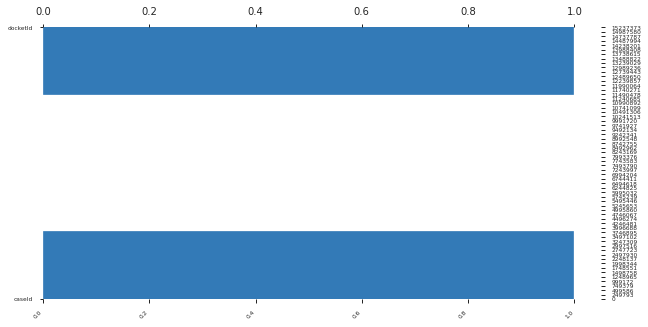

In [ ]:
import pandas_profiling as pp
profile = pp.ProfileReport(data)
profile.to_file(output_file="legacy.html")

In [ ]:
profile.to_notebook_iframe()


In [ ]:
data.dtypes # datatypes of attributes

caseId                          object
docketId                        object
caseIssuesId                    object
voteId                          object
dateDecision                    object
                                ...   
direction                      float64
majority                       float64
firstAgreement                 float64
secondAgreement                float64
justice_outcome_disposition      int64
Length: 62, dtype: object

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249793 entries, 0 to 249792
Data columns (total 62 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   caseId                       249793 non-null  object 
 1   docketId                     249793 non-null  object 
 2   caseIssuesId                 249793 non-null  object 
 3   voteId                       249768 non-null  object 
 4   dateDecision                 249793 non-null  object 
 5   decisionType                 249787 non-null  float64
 6   usCite                       247075 non-null  object 
 7   sctCite                      197674 non-null  object 
 8   ledCite                      249087 non-null  object 
 9   lexisCite                    249793 non-null  object 
 10  term                         249793 non-null  int64  
 11  naturalCourt                 249793 non-null  int64  
 12  chief                        249793 non-null  object 
 13 

In [ ]:
data.describe()

,decisionType,term,naturalCourt,petitioner,petitionerState,respondent,respondentState,jurisdiction,adminAction,adminActionState,...,majVotes,minVotes,justice,vote,opinion,direction,majority,firstAgreement,secondAgreement,justice_outcome_disposition
count,249787.000000,249793.000000,249793.000000,249776.000000,32220.000000,249757.000000,55012.000000,249784.000000,63781.000000,19990.000000,...,249768.000000,249768.000000,249793.000000,240945.000000,240963.000000,207725.000000,239074.000000,12179.000000,1593.000000,249793.000000
mean,1.274510,1920.287014,1019.264155,153.243606,30.943669,135.873489,31.711427,5.075185,80.181041,29.415208,...,7.758396,0.718050,64.869704,1.219635,1.172346,1.524573,1.918874,80.651613,22.836786,0.216167
std,1.070782,46.963386,370.362067,100.921989,17.628408,108.642883,18.059768,5.251732,37.399018,16.520839,...,1.399362,1.261141,25.772551,0.791107,0.388643,0.499397,0.273028,32.039687,41.362699,0.702690
min,1.000000,1791.000000,102.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,-99.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-1.000000
25%,1.000000,1886.000000,706.000000,102.000000,17.000000,28.000000,17.000000,1.000000,63.000000,17.000000,...,7.000000,0.000000,45.000000,1.000000,1.000000,1.000000,2.000000,78.000000,0.000000,0.000000
50%,1.000000,1916.000000,905.000000,145.000000,30.000000,135.000000,30.000000,2.000000,82.000000,30.000000,...,8.000000,0.000000,62.000000,1.000000,1.000000,2.000000,2.000000,92.000000,0.000000,0.000000
75%,1.000000,1960.000000,1406.000000,206.000000,45.000000,195.000000,48.000000,13.000000,117.000000,42.000000,...,9.000000,1.000000,88.000000,1.000000,1.000000,2.000000,2.000000,103.000000,0.000000,1.000000
max,8.000000,2014.000000,1704.000000,600.000000,62.000000,600.000000,63.000000,15.000000,124.000000,62.000000,...,10.000000,4.000000,114.000000,8.000000,3.000000,2.000000,2.000000,114.000000,114.000000,1.000000


In [ ]:
data.describe().shape

(8, 46)

In [ ]:
print("---------")
for column in data.columns:
  print("---------")
  print(column)
  # print('Unique values',data[column].unique())
  print('number of unique values',data[column].unique().shape)
  print("---------")


---------
---------
caseId
number of unique values (28543,)
---------
---------
docketId
number of unique values (28543,)
---------
---------
caseIssuesId
number of unique values (28543,)
---------
---------
voteId
number of unique values (249769,)
---------
---------
dateDecision
number of unique values (5790,)
---------
---------
decisionType
number of unique values (8,)
---------
---------
usCite
number of unique values (28043,)
---------
---------
sctCite
number of unique values (21633,)
---------
---------
ledCite
number of unique values (27606,)
---------
---------
lexisCite
number of unique values (28489,)
---------
---------
term
number of unique values (222,)
---------
---------
naturalCourt
number of unique values (103,)
---------
---------
chief
number of unique values (17,)
---------
---------
docket
number of unique values (6846,)
---------
---------
caseName
number of unique values (27327,)
---------
---------
dateArgument
number of unique values (11416,)
---------
------

In [ ]:
data_numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(data_numeric_cols)
print(len(data_numeric_cols))
data_categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
print(data_categorical_cols)
print(len(data_categorical_cols))

['decisionType', 'term', 'naturalCourt', 'petitioner', 'petitionerState', 'respondent', 'respondentState', 'jurisdiction', 'adminAction', 'adminActionState', 'threeJudgeFdc', 'caseOrigin', 'caseOriginState', 'caseSource', 'caseSourceState', 'lcDisagreement', 'certReason', 'lcDisposition', 'lcDispositionDirection', 'declarationUncon', 'caseDisposition', 'caseDispositionUnusual', 'partyWinning', 'precedentAlteration', 'voteUnclear', 'issue', 'issueArea', 'decisionDirection', 'decisionDirectionDissent', 'authorityDecision1', 'authorityDecision2', 'lawType', 'lawSupp', 'majOpinWriter', 'majOpinAssigner', 'splitVote', 'majVotes', 'minVotes', 'justice', 'vote', 'opinion', 'direction', 'majority', 'firstAgreement', 'secondAgreement', 'justice_outcome_disposition']
46
['caseId', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision', 'usCite', 'sctCite', 'ledCite', 'lexisCite', 'chief', 'docket', 'caseName', 'dateArgument', 'dateRearg', 'lawMinor', 'justiceName']
16


[ 0.  1.  2. nan]


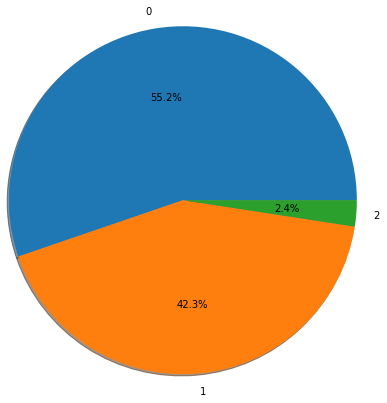

In [ ]:
print(data['partyWinning'].unique())
r = data.groupby('partyWinning')['partyWinning'].count()
plt.pie(r,  radius=2,labels=[0,1,2] ,autopct='%1.1f%%',  shadow=True);

[ 9.  1. 11.  4.  2.  3. nan  6.  7.  5. 10.  8.]


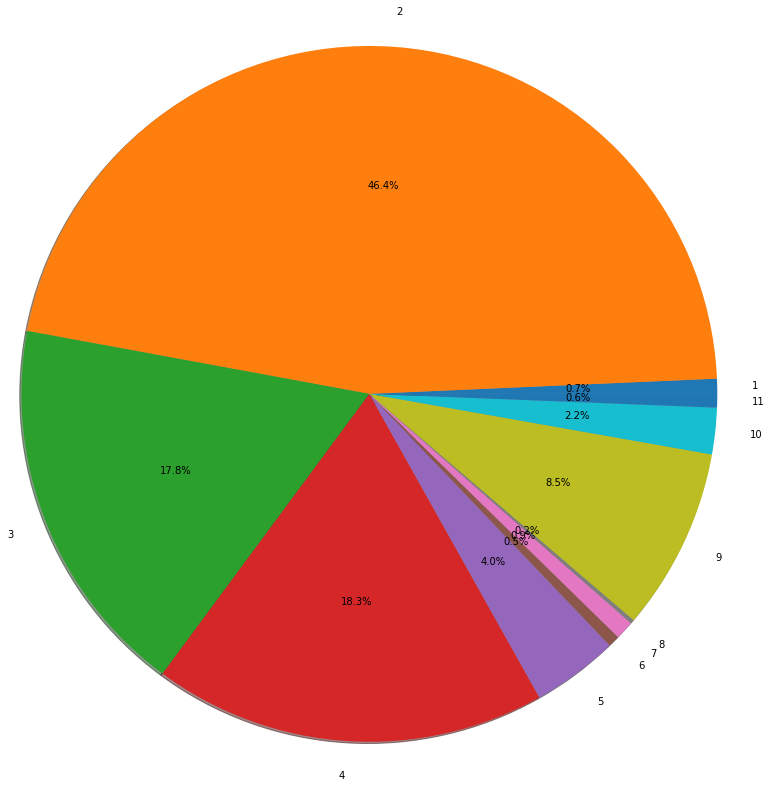

In [ ]:
print(data['caseDisposition'].unique())
r = data.groupby('caseDisposition')['caseDisposition'].count()
plt.pie(r,  radius=4,labels=[1,2,3,4,5,6,7,8,9,10,11] ,autopct='%1.1f%%',  shadow=True);

[-1  1  0]


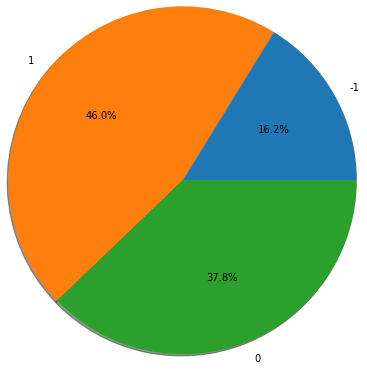

In [ ]:
print(data['justice_outcome_disposition'].unique())
r = data.groupby('justice_outcome_disposition')['justice_outcome_disposition'].count()
plt.pie(r,  radius=2,labels=[-1,1,0] ,autopct='%1.1f%%',  shadow=True);

In [ ]:
data_numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(data_numeric_cols)
print(len(data_numeric_cols))
data_categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
print(data_categorical_cols)
print(len(data_categorical_cols))

['decisionType', 'term', 'naturalCourt', 'petitioner', 'petitionerState', 'respondent', 'respondentState', 'jurisdiction', 'adminAction', 'adminActionState', 'threeJudgeFdc', 'caseOrigin', 'caseOriginState', 'caseSource', 'caseSourceState', 'lcDisagreement', 'certReason', 'lcDisposition', 'lcDispositionDirection', 'declarationUncon', 'caseDisposition', 'caseDispositionUnusual', 'partyWinning', 'precedentAlteration', 'voteUnclear', 'issue', 'issueArea', 'decisionDirection', 'decisionDirectionDissent', 'authorityDecision1', 'authorityDecision2', 'lawType', 'lawSupp', 'majOpinWriter', 'majOpinAssigner', 'splitVote', 'majVotes', 'minVotes', 'justice', 'vote', 'opinion', 'direction', 'majority', 'firstAgreement', 'secondAgreement', 'justice_outcome_disposition']
46
['caseId', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision', 'usCite', 'sctCite', 'ledCite', 'lexisCite', 'chief', 'docket', 'caseName', 'dateArgument', 'dateRearg', 'lawMinor', 'justiceName']
16


In [ ]:
data=data.drop(data_categorical_cols,axis=1)

In [ ]:
data.head()

,decisionType,term,naturalCourt,petitioner,petitionerState,respondent,respondentState,jurisdiction,adminAction,adminActionState,...,majVotes,minVotes,justice,vote,opinion,direction,majority,firstAgreement,secondAgreement,justice_outcome_disposition
0,6.0,1791,102,501.0,NaN,111.0,NaN,13.0,NaN,NaN,...,5.0,0.0,1,1.0,1.0,1.0,2.0,NaN,NaN,-1
1,6.0,1791,102,501.0,NaN,111.0,NaN,13.0,NaN,NaN,...,5.0,0.0,3,1.0,1.0,1.0,2.0,NaN,NaN,-1
2,6.0,1791,102,501.0,NaN,111.0,NaN,13.0,NaN,NaN,...,5.0,0.0,4,1.0,1.0,1.0,2.0,NaN,NaN,-1
3,6.0,1791,102,501.0,NaN,111.0,NaN,13.0,NaN,NaN,...,5.0,0.0,5,1.0,1.0,1.0,2.0,NaN,NaN,-1
4,6.0,1791,102,501.0,NaN,111.0,NaN,13.0,NaN,NaN,...,5.0,0.0,6,1.0,1.0,1.0,2.0,NaN,NaN,-1


In [ ]:

#Dropping rows or columns with 60% NaN values
perc = 60.0
min_count =  int(((100-perc)/100)*data.shape[0] + 1)
data = data.dropna( axis=1,
                thresh=min_count)

In [ ]:
data.head()

,decisionType,term,naturalCourt,petitioner,respondent,jurisdiction,threeJudgeFdc,caseOrigin,caseSource,lcDisagreement,...,majOpinAssigner,splitVote,majVotes,minVotes,justice,vote,opinion,direction,majority,justice_outcome_disposition
0,6.0,1791,102,501.0,111.0,13.0,0.0,431.0,431.0,0.0,...,1.0,1,5.0,0.0,1,1.0,1.0,1.0,2.0,-1
1,6.0,1791,102,501.0,111.0,13.0,0.0,431.0,431.0,0.0,...,1.0,1,5.0,0.0,3,1.0,1.0,1.0,2.0,-1
2,6.0,1791,102,501.0,111.0,13.0,0.0,431.0,431.0,0.0,...,1.0,1,5.0,0.0,4,1.0,1.0,1.0,2.0,-1
3,6.0,1791,102,501.0,111.0,13.0,0.0,431.0,431.0,0.0,...,1.0,1,5.0,0.0,5,1.0,1.0,1.0,2.0,-1
4,6.0,1791,102,501.0,111.0,13.0,0.0,431.0,431.0,0.0,...,1.0,1,5.0,0.0,6,1.0,1.0,1.0,2.0,-1


In [ ]:
data = data.drop(['decisionType', 'declarationUncon', 'caseDispositionUnusual', 'precedentAlteration'],axis=1)

In [ ]:
data.head()

,term,naturalCourt,petitioner,respondent,jurisdiction,threeJudgeFdc,caseOrigin,caseSource,lcDisagreement,certReason,...,majOpinAssigner,splitVote,majVotes,minVotes,justice,vote,opinion,direction,majority,justice_outcome_disposition
0,1791,102,501.0,111.0,13.0,0.0,431.0,431.0,0.0,1.0,...,1.0,1,5.0,0.0,1,1.0,1.0,1.0,2.0,-1
1,1791,102,501.0,111.0,13.0,0.0,431.0,431.0,0.0,1.0,...,1.0,1,5.0,0.0,3,1.0,1.0,1.0,2.0,-1
2,1791,102,501.0,111.0,13.0,0.0,431.0,431.0,0.0,1.0,...,1.0,1,5.0,0.0,4,1.0,1.0,1.0,2.0,-1
3,1791,102,501.0,111.0,13.0,0.0,431.0,431.0,0.0,1.0,...,1.0,1,5.0,0.0,5,1.0,1.0,1.0,2.0,-1
4,1791,102,501.0,111.0,13.0,0.0,431.0,431.0,0.0,1.0,...,1.0,1,5.0,0.0,6,1.0,1.0,1.0,2.0,-1


<Axes: >

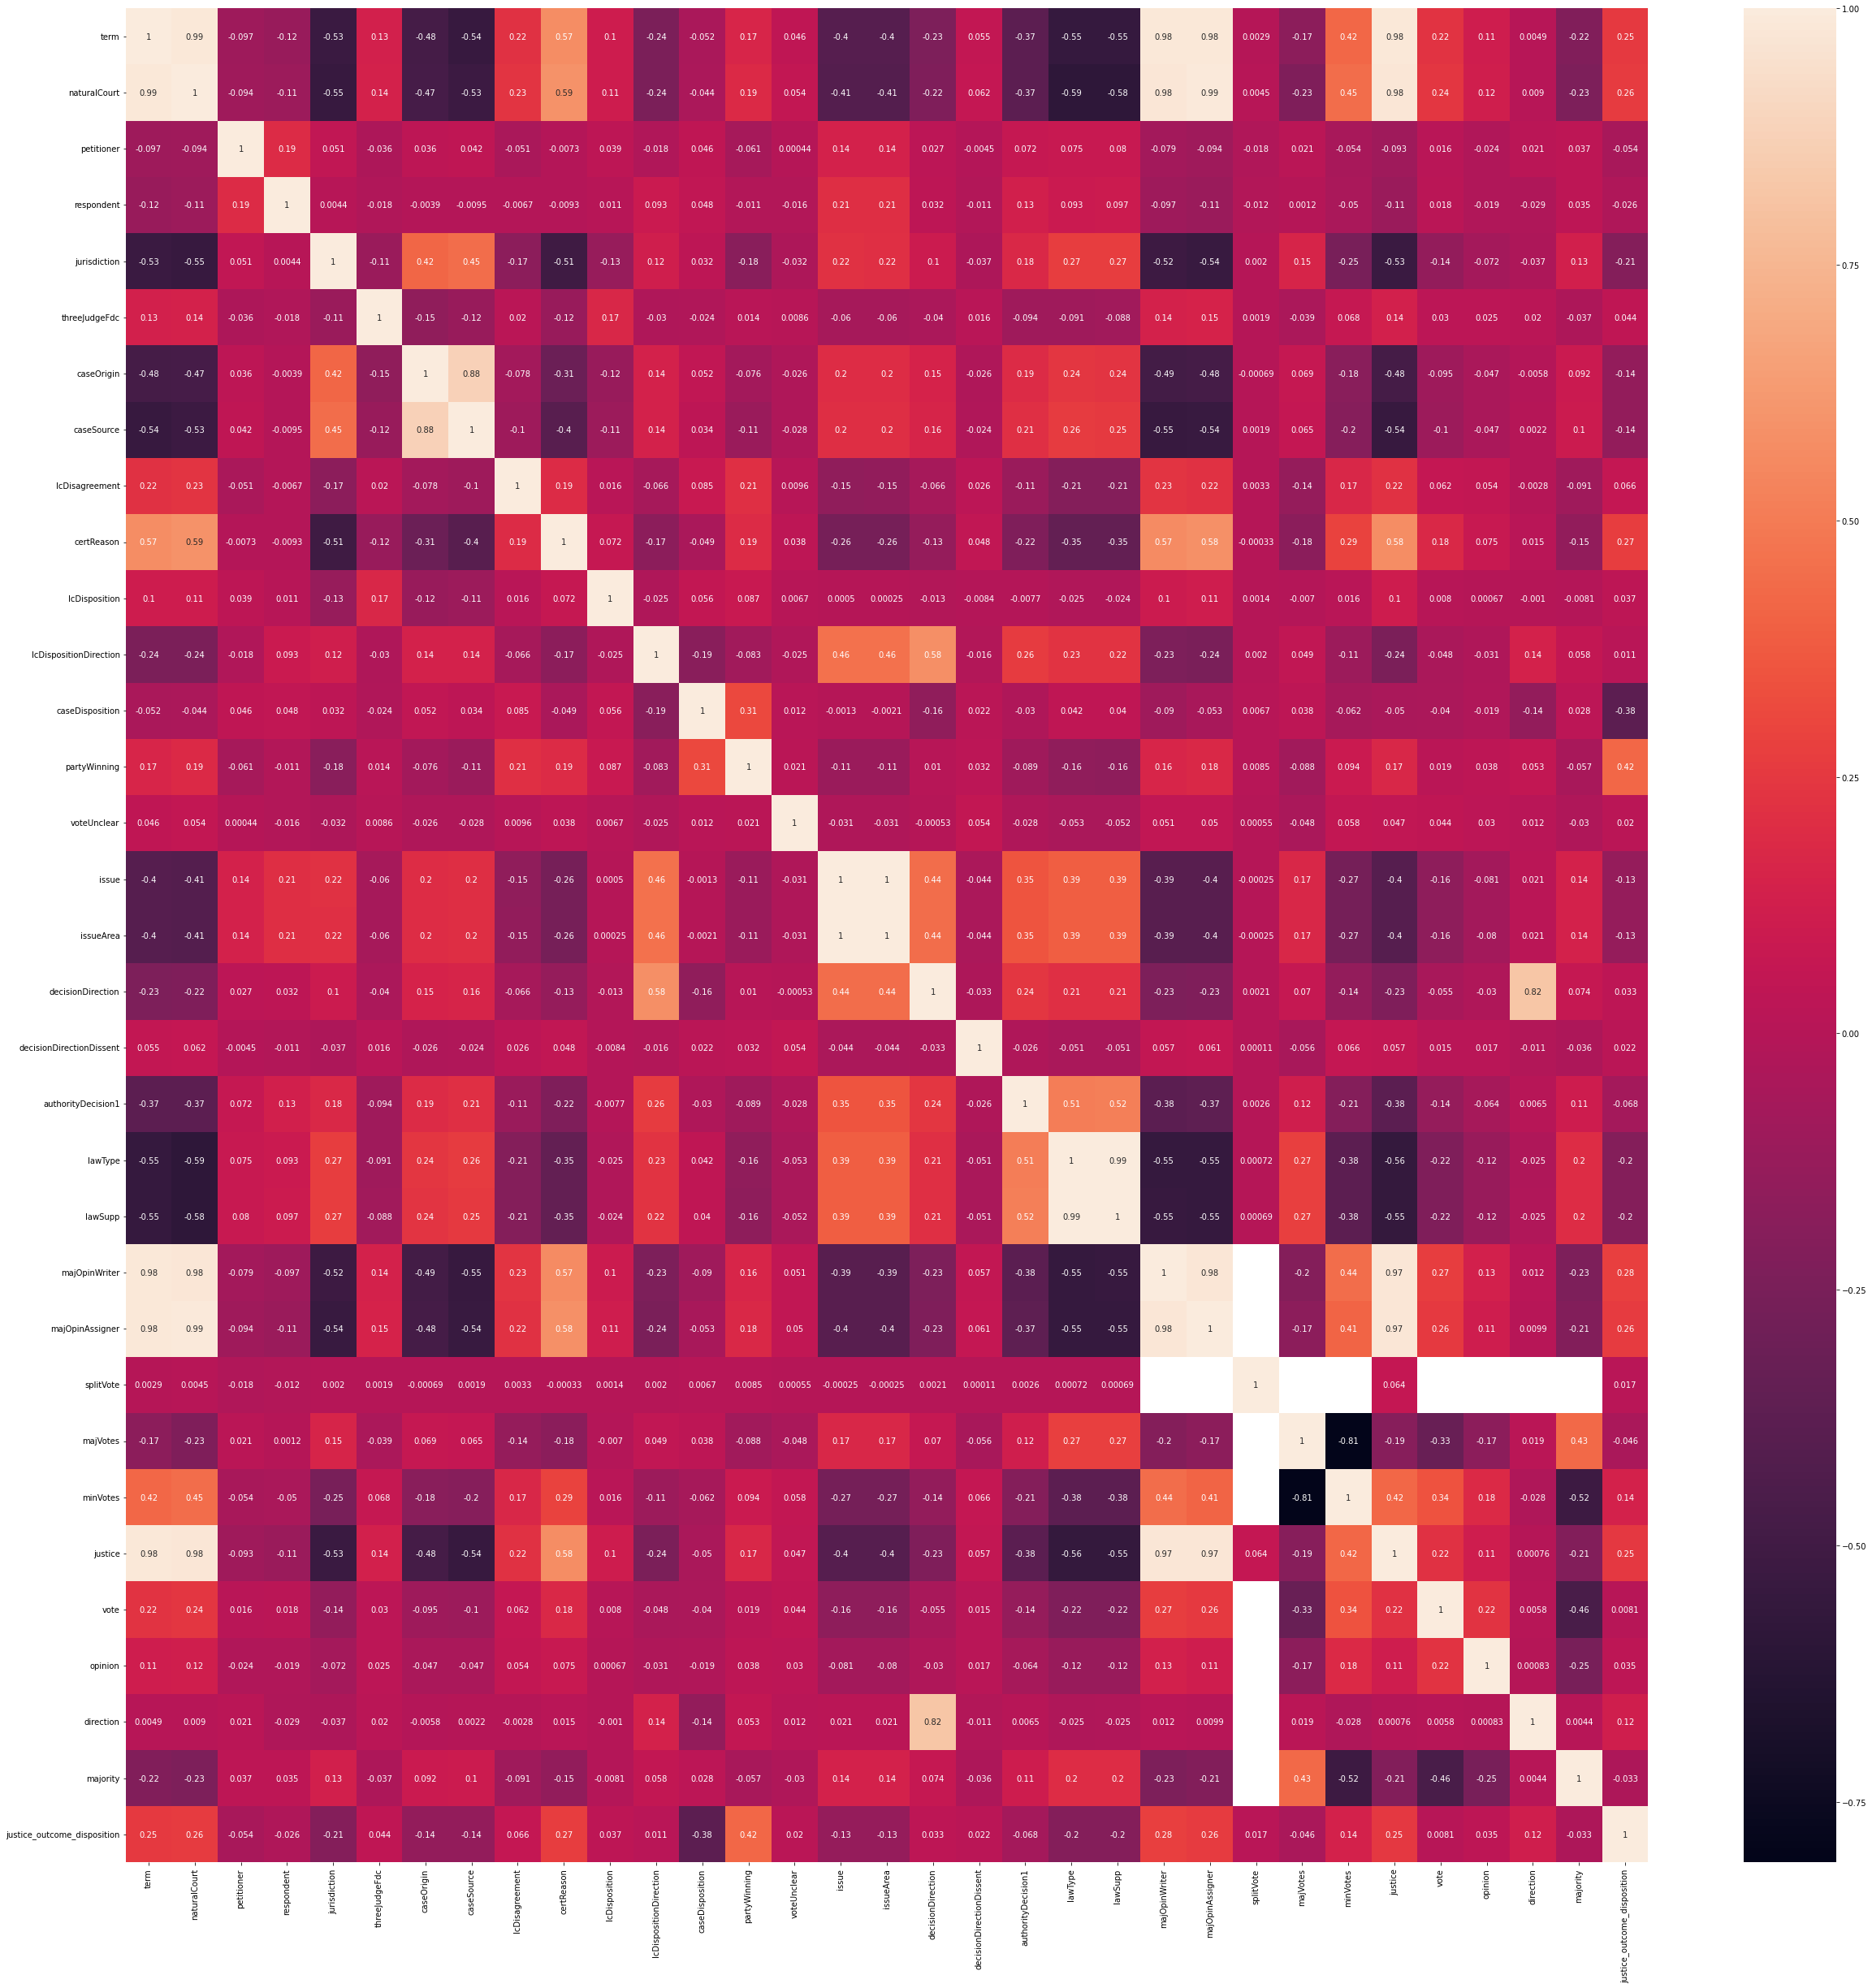

In [ ]:
plt.figure(figsize=(42,42))
sns.heatmap(data.corr(),annot=True)

In [ ]:
data.mean()

term                            1920.287014
naturalCourt                    1019.264155
petitioner                       153.243606
respondent                       135.873489
jurisdiction                       5.075185
threeJudgeFdc                      0.034805
caseOrigin                       212.675420
caseSource                       191.361023
lcDisagreement                     0.095496
certReason                         4.053019
lcDisposition                      3.076803
lcDispositionDirection             1.659084
caseDisposition                    3.555364
partyWinning                       0.471819
voteUnclear                        0.003523
issue                          75298.993063
issueArea                          7.516346
decisionDirection                  1.715158
decisionDirectionDissent           0.002820
authorityDecision1                 4.212628
lawType                            6.194234
lawSupp                          629.280688
majOpinWriter                   

In [ ]:
data.max()

term                             2014.0
naturalCourt                     1704.0
petitioner                        600.0
respondent                        600.0
jurisdiction                       15.0
threeJudgeFdc                       1.0
caseOrigin                        601.0
caseSource                        601.0
lcDisagreement                      1.0
certReason                         13.0
lcDisposition                      12.0
lcDispositionDirection              3.0
caseDisposition                    11.0
partyWinning                        2.0
voteUnclear                         1.0
issue                          140080.0
issueArea                          14.0
decisionDirection                   3.0
decisionDirectionDissent            1.0
authorityDecision1                  7.0
lawType                             9.0
lawSupp                           900.0
majOpinWriter                     114.0
majOpinAssigner                   111.0
splitVote                           1.0


In [ ]:
data.median()

term                            1916.0
naturalCourt                     905.0
petitioner                       145.0
respondent                       135.0
jurisdiction                       2.0
threeJudgeFdc                      0.0
caseOrigin                       133.0
caseSource                       106.0
lcDisagreement                     0.0
certReason                         1.0
lcDisposition                      2.0
lcDispositionDirection             2.0
caseDisposition                    3.0
partyWinning                       0.0
voteUnclear                        0.0
issue                          80110.0
issueArea                          8.0
decisionDirection                  2.0
decisionDirectionDissent           0.0
authorityDecision1                 4.0
lawType                            6.0
lawSupp                          600.0
majOpinWriter                     59.0
majOpinAssigner                   56.0
splitVote                          1.0
majVotes                 

In [ ]:
data.min()

term                            1791.0
naturalCourt                     102.0
petitioner                         1.0
respondent                         1.0
jurisdiction                       1.0
threeJudgeFdc                      0.0
caseOrigin                         1.0
caseSource                         1.0
lcDisagreement                     0.0
certReason                         1.0
lcDisposition                      1.0
lcDispositionDirection             1.0
caseDisposition                    1.0
partyWinning                       0.0
voteUnclear                        0.0
issue                          10010.0
issueArea                          1.0
decisionDirection                  1.0
decisionDirectionDissent           0.0
authorityDecision1                 1.0
lawType                            1.0
lawSupp                          100.0
majOpinWriter                      1.0
majOpinAssigner                    1.0
splitVote                        -99.0
majVotes                 

In [ ]:
data.mode()

,term,naturalCourt,petitioner,respondent,jurisdiction,threeJudgeFdc,caseOrigin,caseSource,lcDisagreement,certReason,...,majOpinAssigner,splitVote,majVotes,minVotes,justice,vote,opinion,direction,majority,justice_outcome_disposition
0,1890,706,27.0,27.0,1.0,0.0,302.0,300.0,0.0,1.0,...,51.0,1,9.0,0.0,45,1.0,1.0,2.0,2.0,0


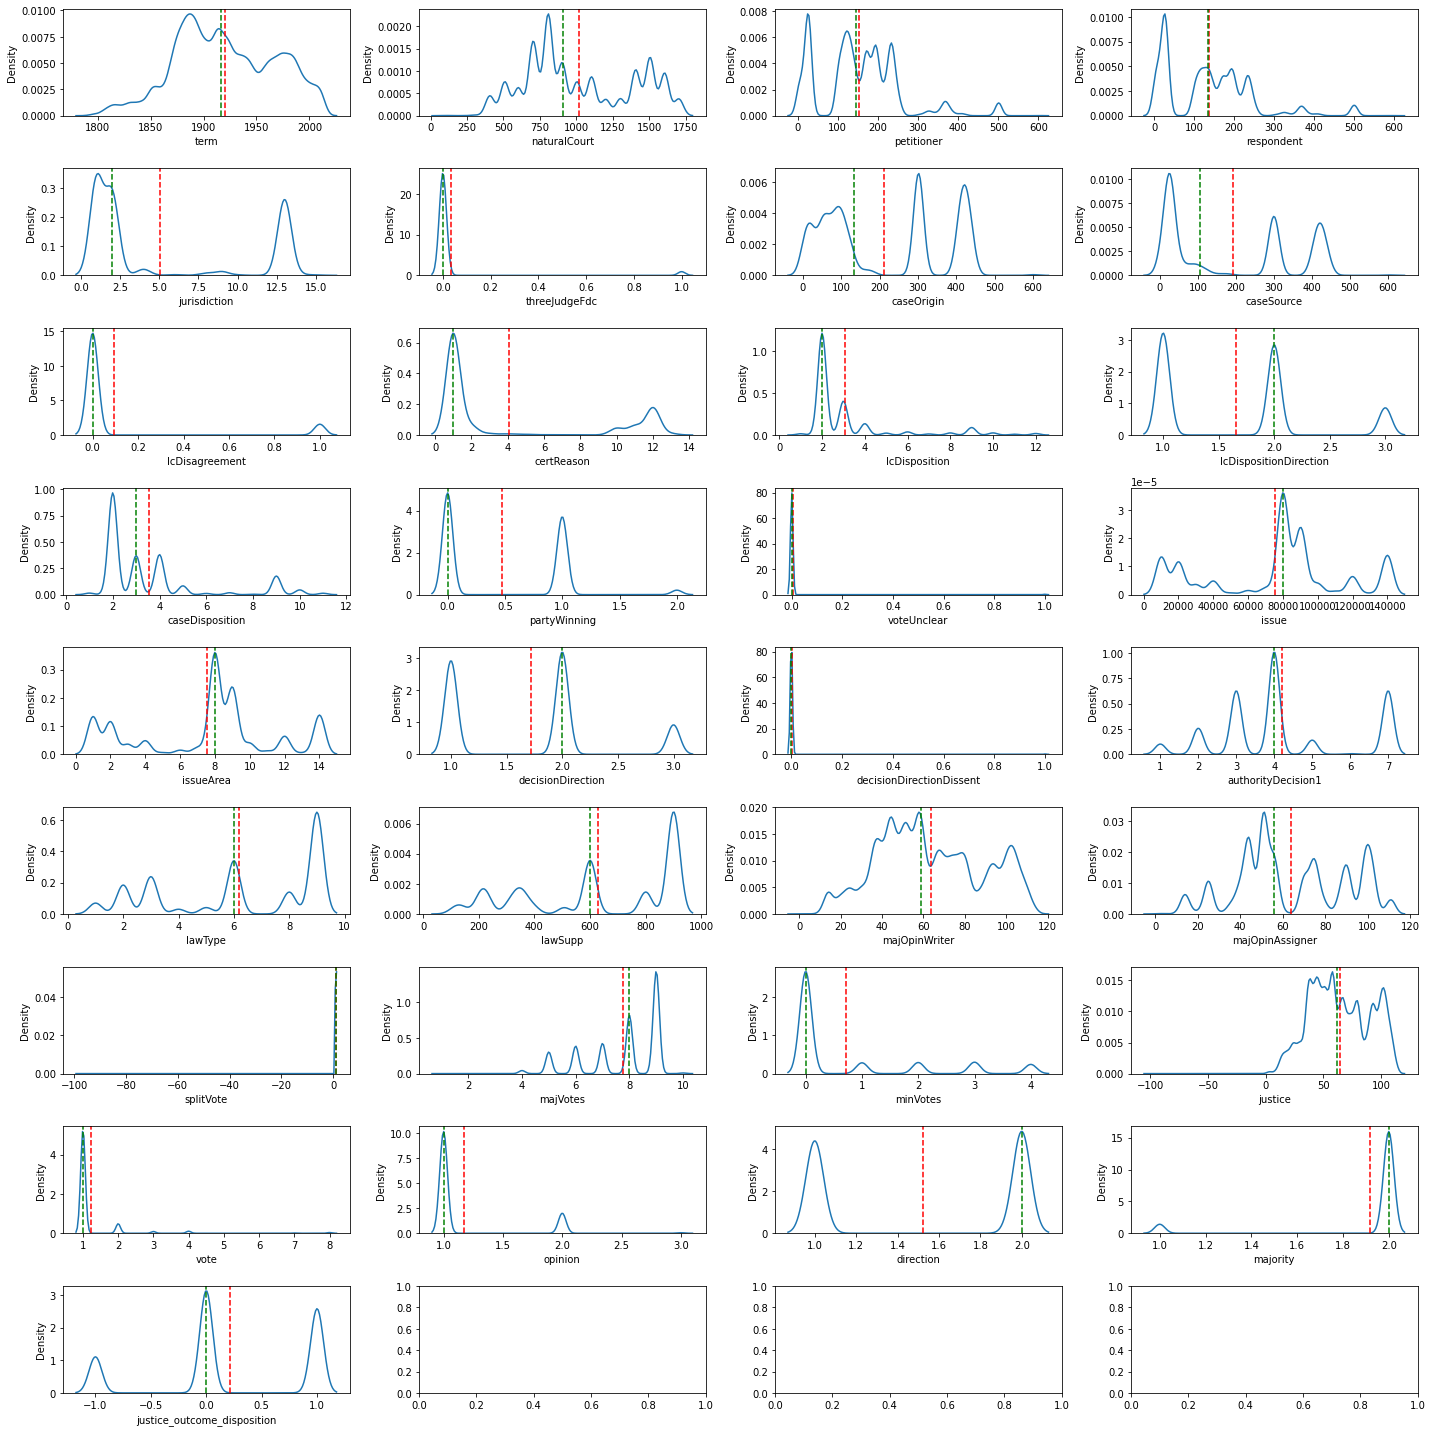

In [ ]:
fig, ax = plt.subplots(9,4, figsize = (20,20))

ax = np.ravel(ax)
for i in range(len(data.columns)):
    sns.kdeplot(data[data.columns[i]], ax = ax[i])
    ax[i].axvline(data[data.columns[i]].mean(), linestyle = '--', color = "red")
    ax[i].axvline(data[data.columns[i]].median(), linestyle = '--', color = "green")

# for i in range(len(data_numeric_cols), 6*5):
#     ax[i].axis("off")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(6,4, figsize = (16,16))

ax = np.ravel(ax)
for i in range(len(data.columns)):
    data_wide = data.pivot(columns ='partyWinning' ,
                     values = data.columns[i])
    data_wide.plot.kde(ax = ax[i],figsize = (20, 20))
    ax[i].axvline(data[data.columns[i]].mean(), linestyle = '--', color = "red")
    ax[i].axvline(data[data.columns[i]].median(), linestyle = '--', color = "green")
    ax[i].set_xlabel(data.columns[i])



# for i in range(len(data_numeric_cols), 6*5):
#     ax[i].axis("off")

plt.tight_layout()

In [ ]:
skewdf=pd.DataFrame(columns=["Attribute","SkewValue","SkewStatus"])

for i in range(len(data.columns)):
  skew=data[data.columns[i]].skew()
  if(skew>1 or skew<-1):
    skewcomment="Highly skewed"
  elif((skew<-1 and skew>0.5) or (skew>0.5 and skew<1)):
    skewcomment="Moderately skewed"
  else:
    skewcomment="Approximately symmetric"

  skewdf=skewdf.append({'Attribute':data.columns[i],'SkewValue':data[data.columns[i]].skew(),'SkewStatus':skewcomment},ignore_index=True)

  #print(data_numeric_cols[i],"  ",data[data_numeric_cols[i]].skew()," ",skewcomment)
skewdf



<ipython-input-72-c6b0ff8376cc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  skewdf=skewdf.append({'Attribute':data.columns[i],'SkewValue':data[data.columns[i]].skew(),'SkewStatus':skewcomment},ignore_index=True)
<ipython-input-72-c6b0ff8376cc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  skewdf=skewdf.append({'Attribute':data.columns[i],'SkewValue':data[data.columns[i]].skew(),'SkewStatus':skewcomment},ignore_index=True)
<ipython-input-72-c6b0ff8376cc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  skewdf=skewdf.append({'Attribute':data.columns[i],'SkewValue':data[data.columns[i]].skew(),'SkewStatus':skewcomment},ignore_index=True)
<ipython-input-72-c6b0ff8376cc>:12: FutureWarning: The frame.append method is d

,Attribute,SkewValue,SkewStatus
0,term,0.023060,Approximately symmetric
1,naturalCourt,0.300545,Approximately symmetric
2,petitioner,0.886770,Moderately skewed
3,respondent,1.039897,Highly skewed
4,jurisdiction,0.793449,Moderately skewed
5,threeJudgeFdc,5.076195,Highly skewed
6,caseOrigin,0.183647,Approximately symmetric
7,caseSource,0.256145,Approximately symmetric
8,lcDisagreement,2.752687,Highly skewed
9,certReason,0.979937,Moderately skewed


In [ ]:

covariance=data.cov()
covariance

,term,naturalCourt,petitioner,respondent,jurisdiction,threeJudgeFdc,caseOrigin,caseSource,lcDisagreement,certReason,...,majOpinAssigner,splitVote,majVotes,minVotes,justice,vote,opinion,direction,majority,justice_outcome_disposition
term,2205.559645,1.714612e+04,-457.567199,-603.648127,-130.103291,1.137856,-3.575249e+03,-4.370702e+03,2.989347,126.025441,...,1181.289669,0.135783,-11.300625,24.972549,1187.801873,8.300731,2.011670,0.112870,-2.779112,8.322977
naturalCourt,17146.115735,1.371681e+05,-3511.956242,-4382.461981,-1063.178991,9.463154,-2.774671e+04,-3.326346e+04,25.537437,1025.039935,...,9343.920837,1.682441,-117.089504,208.675699,9312.902657,69.736434,17.300756,1.654776,-23.309707,68.040239
petitioner,-457.567199,-3.511956e+03,10185.247828,2124.332542,27.249219,-0.660865,5.621815e+02,7.155225e+02,-1.498118,-3.473274,...,-240.516789,-1.854433,2.950162,-6.815156,-243.049746,1.263595,-0.934086,1.086683,1.008045,-3.811539
respondent,-603.648127,-4.382462e+03,2124.332542,11803.276084,2.531011,-0.356953,-6.595410e+01,-1.751914e+02,-0.214992,-4.729275,...,-313.062057,-1.264048,0.187086,-6.826214,-321.171810,1.578262,-0.810657,-1.618630,1.020997,-1.977223
jurisdiction,-130.103291,-1.063179e+03,27.249219,2.531011,27.580684,-0.106674,3.470726e+02,4.013996e+02,-0.261327,-12.480123,...,-72.630399,0.010331,1.121981,-1.687259,-71.537613,-0.590136,-0.146877,-0.094382,0.187502,-0.766657
threeJudgeFdc,1.137856,9.463154e+00,-0.660865,-0.356953,-0.106674,0.033594,-4.498575e+00,-3.701874e+00,0.001054,-0.101836,...,0.689263,0.000335,-0.010044,0.015808,0.650774,0.004342,0.001774,0.001966,-0.001857,0.005637
caseOrigin,-3575.249263,-2.774671e+04,562.181498,-65.954097,347.072640,-4.498575,2.511147e+04,2.381163e+04,-3.680270,-232.790771,...,-1953.334179,-0.088516,15.204290,-36.135316,-1961.232960,-10.842075,-2.880810,-0.445774,4.007511,-15.530459
caseSource,-4370.702128,-3.326346e+04,715.522503,-175.191382,401.399583,-3.701874,2.381163e+04,2.931470e+04,-5.126808,-321.885704,...,-2345.251875,0.327550,15.669543,-43.528923,-2382.975479,-14.021702,-3.150261,0.178810,4.737393,-16.886927
lcDisagreement,2.989347,2.553744e+01,-1.498118,-0.214992,-0.261327,0.001054,-3.680270e+00,-5.126808e+00,0.086377,0.263642,...,1.642842,0.000957,-0.055584,0.061925,1.643710,0.014399,0.006195,-0.000426,-0.007338,0.013584
certReason,126.025441,1.025040e+03,-3.473274,-4.729275,-12.480123,-0.101836,-2.327908e+02,-3.218857e+02,0.263642,21.967058,...,69.680588,-0.001497,-1.170379,1.708598,69.345492,0.637596,0.137833,0.037102,-0.187549,0.880858


<Axes: >

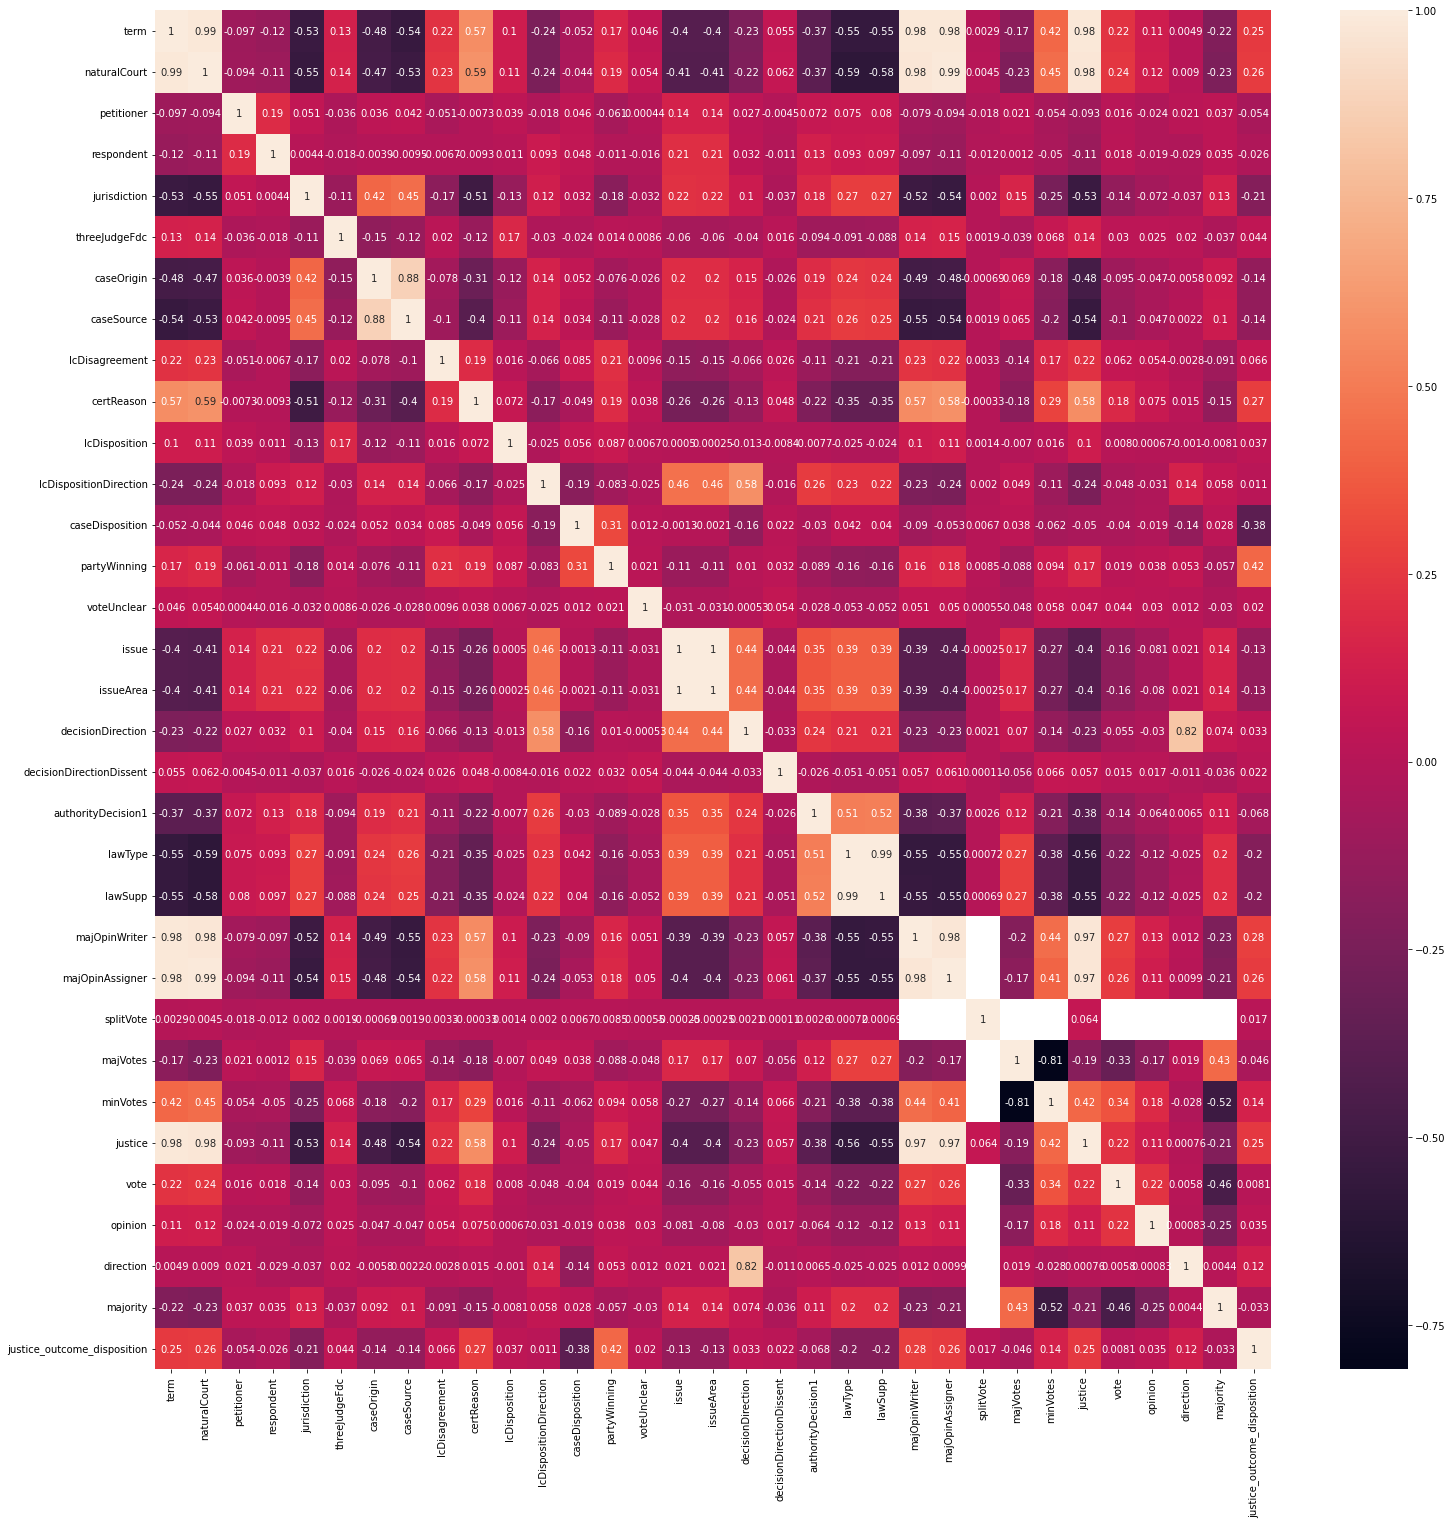

In [ ]:
plt.figure(figsize=(25,25))
sns.heatmap(data.corr(),annot=True)

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


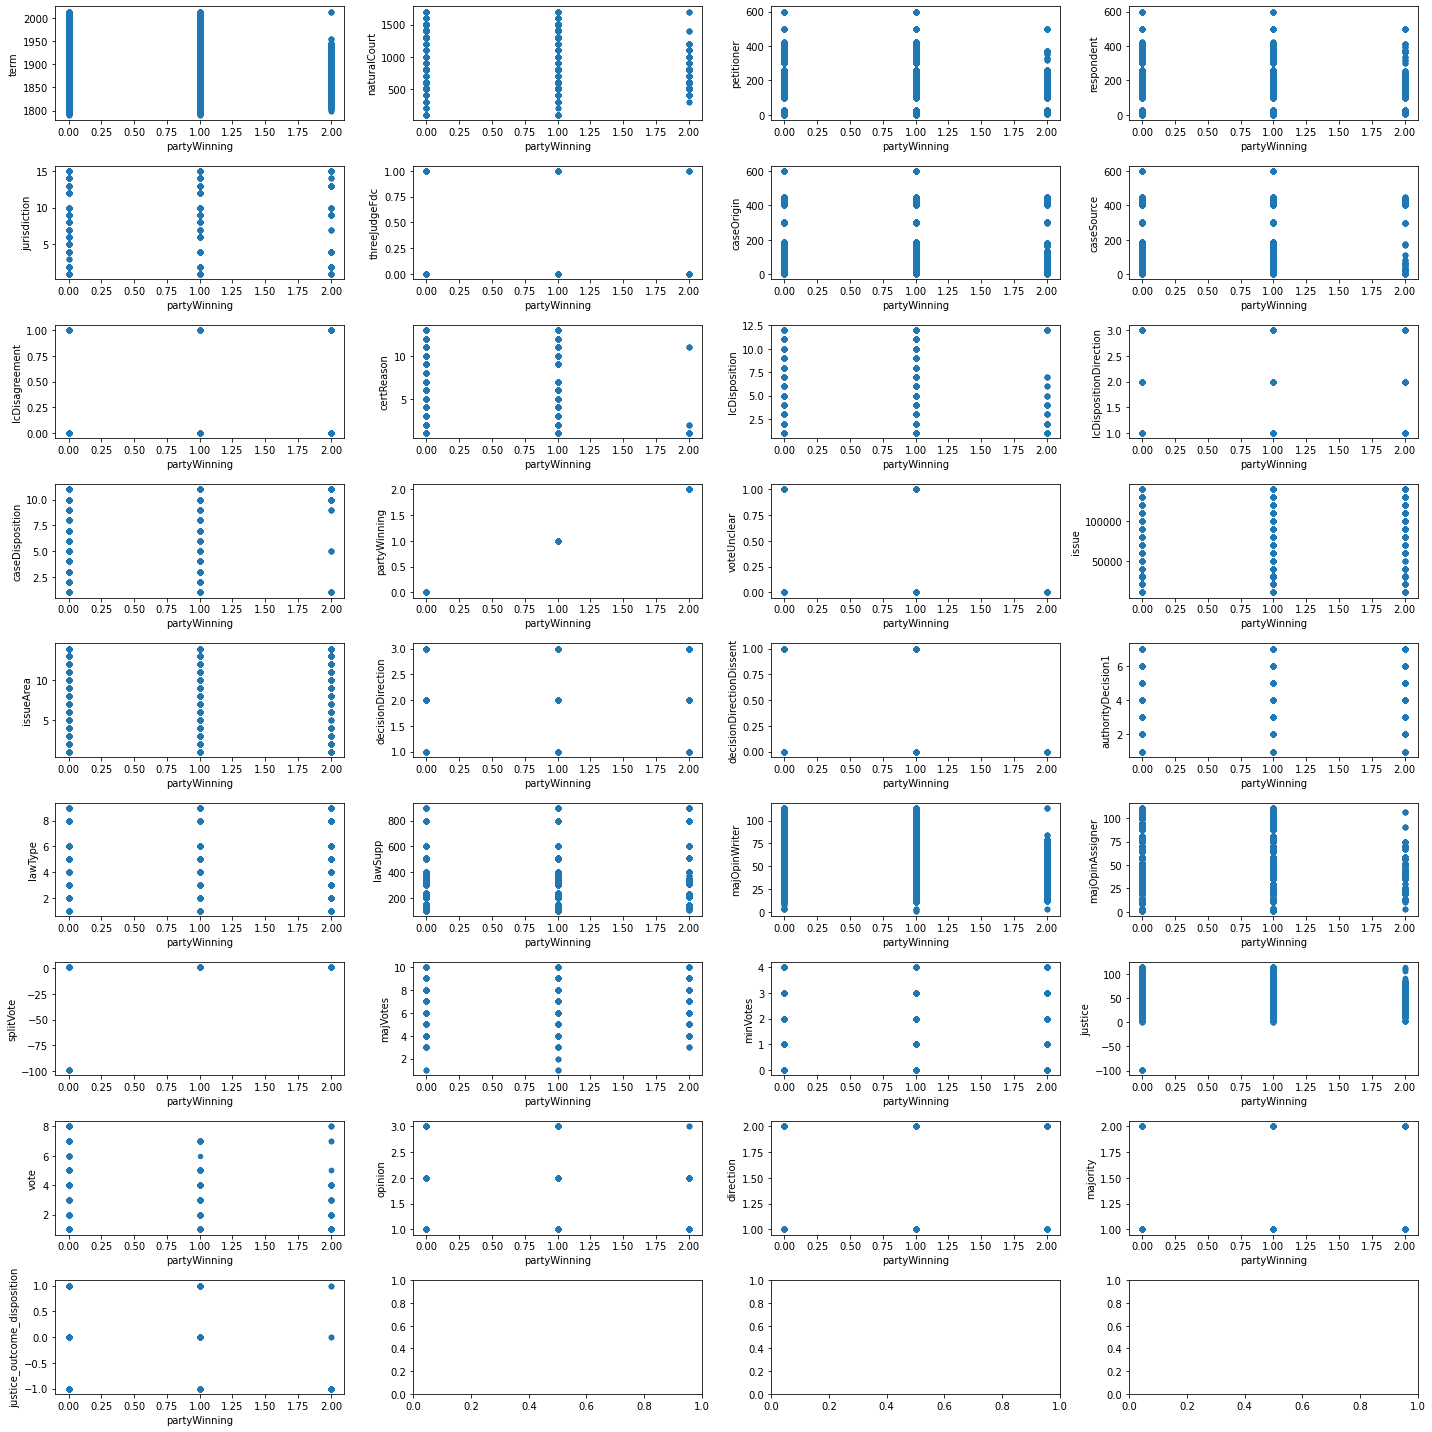

In [ ]:
fig, ax = plt.subplots(9,4, figsize = (20,20))

ax = np.ravel(ax)
for i in range(len(data.columns)):
    data.plot(y=data.columns[i],x='partyWinning',kind='scatter',ax=ax[i])

# for i in range(len(data_numeric_cols), 6*5):
#     ax[i].axis("off")

plt.tight_layout()

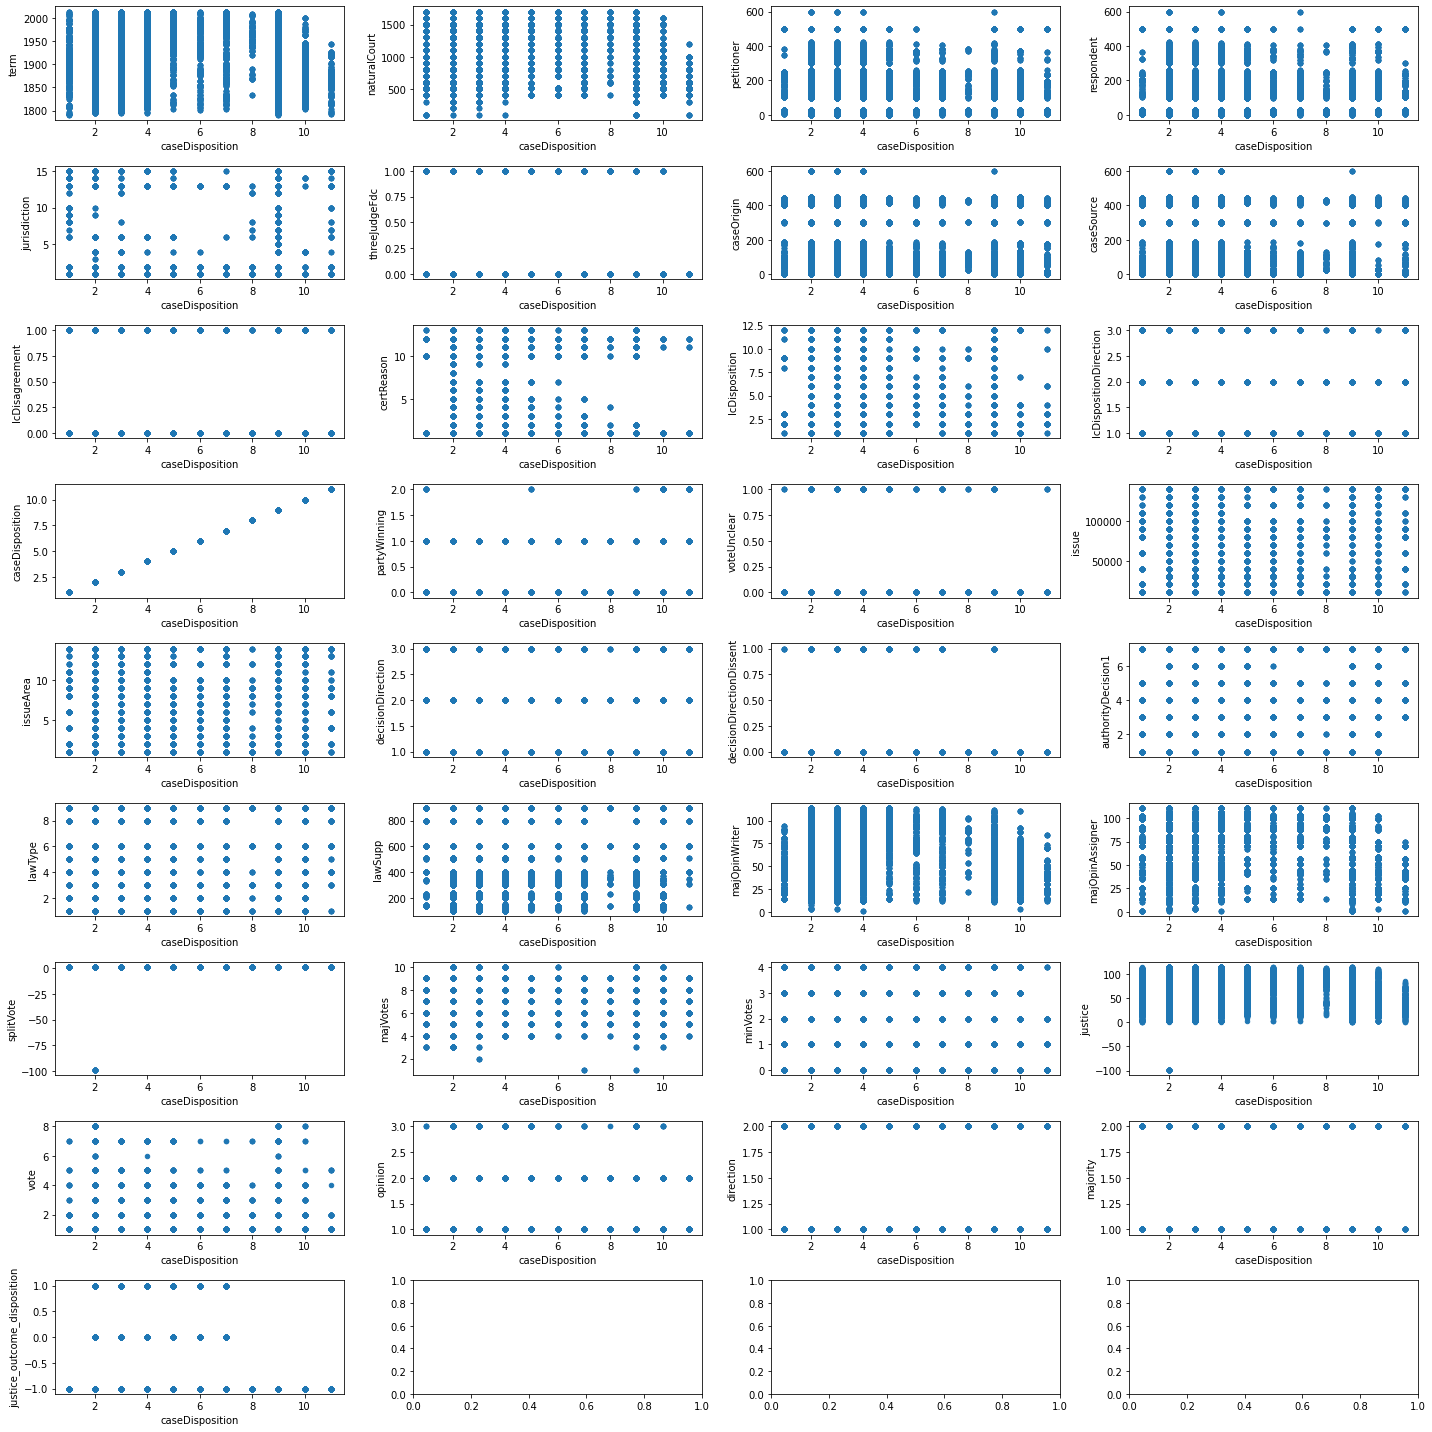

In [ ]:
fig, ax = plt.subplots(9,4, figsize = (20,20))

ax = np.ravel(ax)
for i in range(len(data.columns)):
    data.plot(y=data.columns[i],x='caseDisposition',kind='scatter',ax=ax[i])

# for i in range(len(data_numeric_cols), 6*5):
#     ax[i].axis("off")

plt.tight_layout()

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


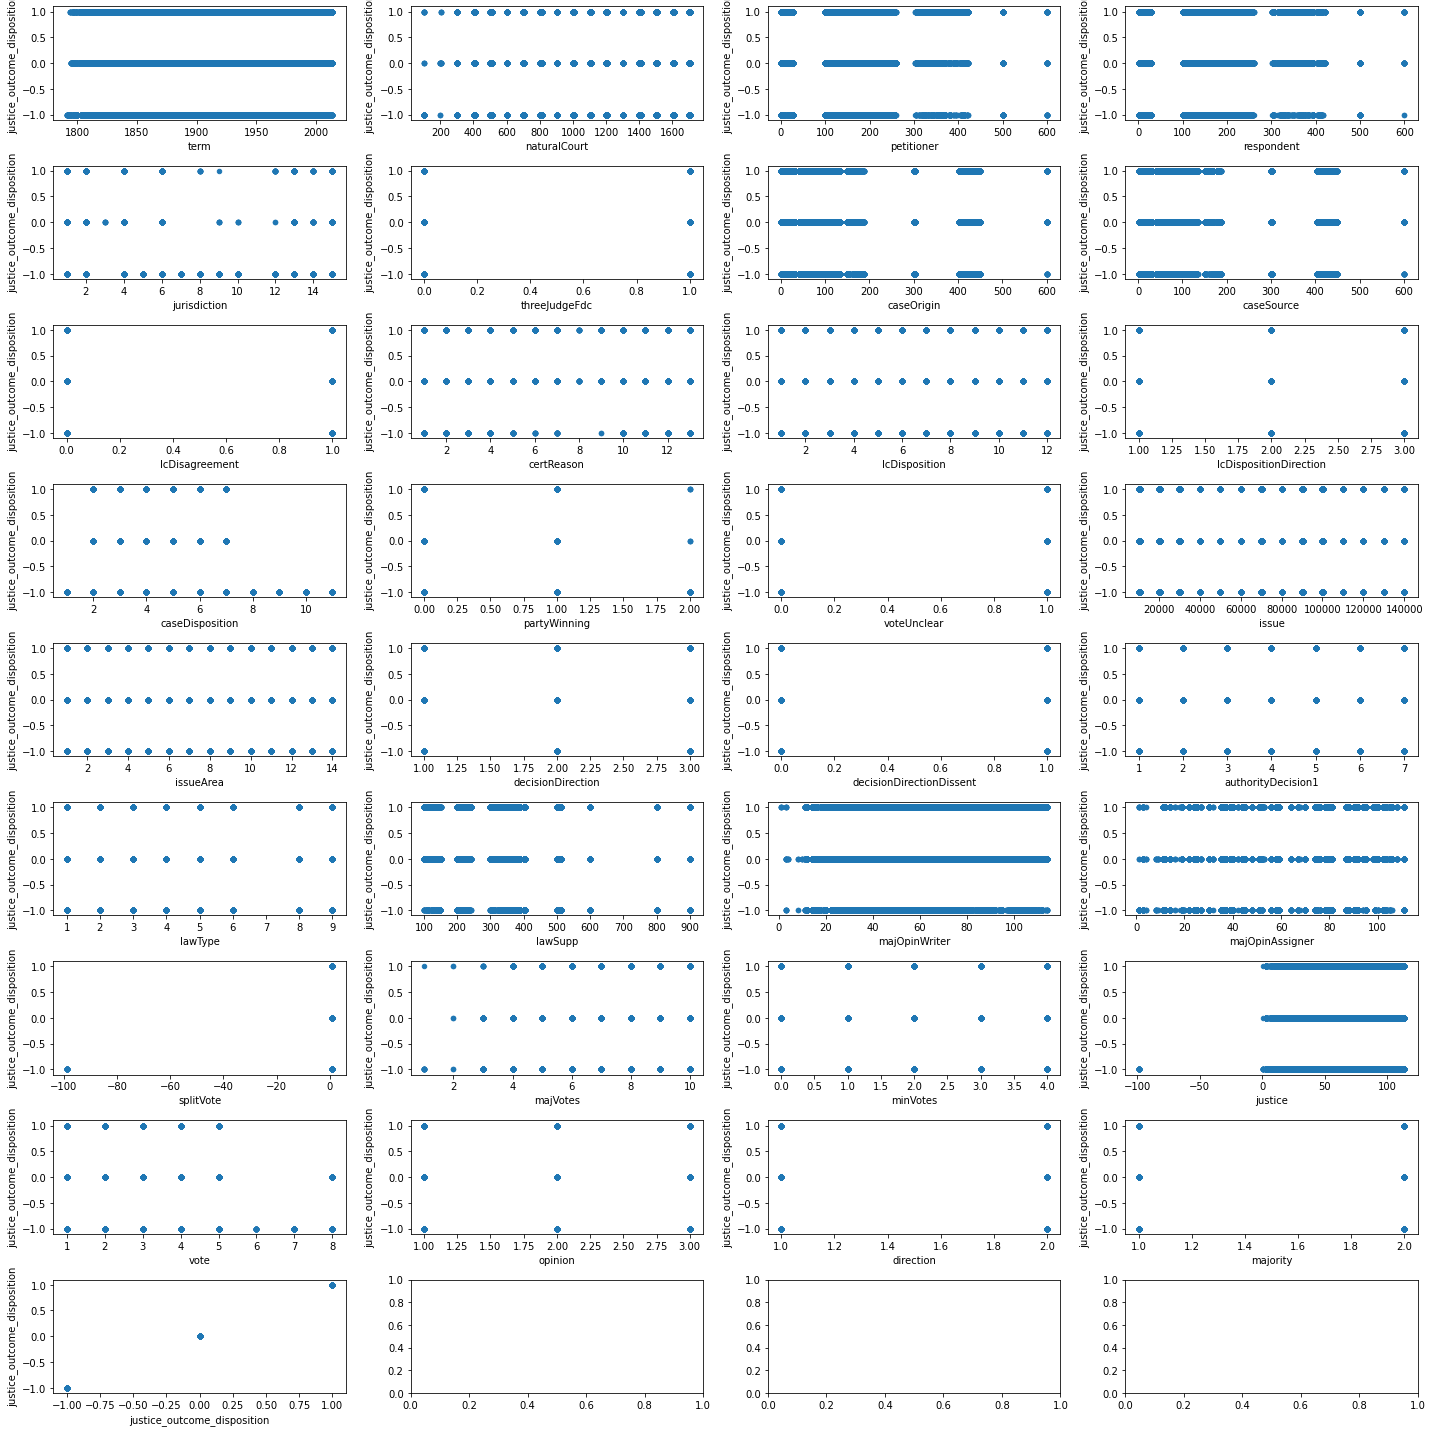

In [ ]:
fig, ax = plt.subplots(9,4, figsize = (20,20))

ax = np.ravel(ax)
for i in range(len(data.columns)):
    data.plot(x=data.columns[i],y='justice_outcome_disposition',kind='scatter',ax=ax[i])

# for i in range(len(data_numeric_cols), 6*5):
#     ax[i].axis("off")

plt.tight_layout()

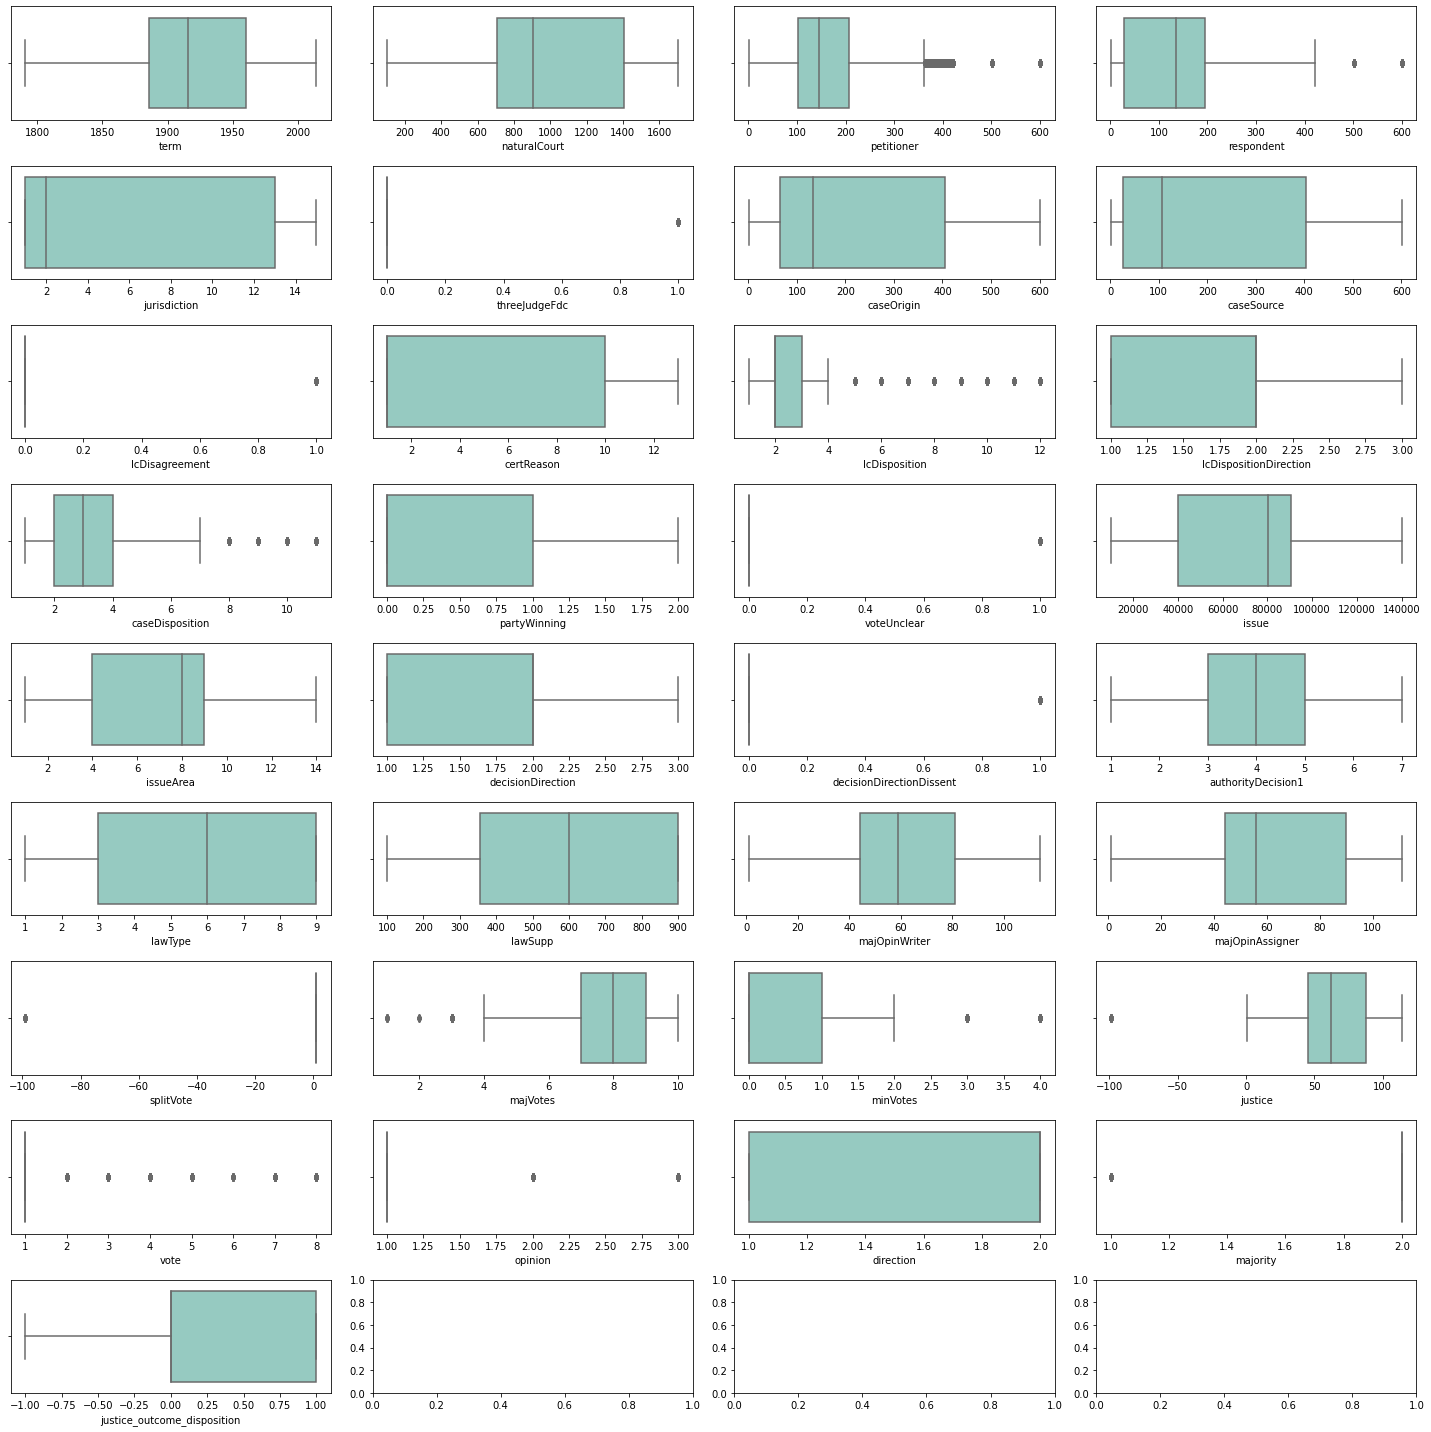

In [ ]:

fig, ax = plt.subplots(9,4, figsize = (20,20))

ax = np.ravel(ax)
for i in range(len(data.columns)):
  sns.boxplot(ax = ax[i],palette = "Set3",x = data[data.columns[i]])




# for i in range(len(data_numeric_cols), 6*5):
#     ax[i].axis("off")

plt.tight_layout()

In [ ]:
Q1=data.quantile(0.25)
Q3=data.quantile(0.75)
IQR=Q3-Q1
print(IQR)

term                              74.0
naturalCourt                     700.0
petitioner                       104.0
respondent                       167.0
jurisdiction                      12.0
threeJudgeFdc                      0.0
caseOrigin                       339.0
caseSource                       377.0
lcDisagreement                     0.0
certReason                         9.0
lcDisposition                      1.0
lcDispositionDirection             1.0
caseDisposition                    2.0
partyWinning                       1.0
voteUnclear                        0.0
issue                          50360.0
issueArea                          5.0
decisionDirection                  1.0
decisionDirectionDissent           0.0
authorityDecision1                 2.0
lawType                            6.0
lawSupp                          544.0
majOpinWriter                     37.0
majOpinAssigner                   46.0
splitVote                          0.0
majVotes                 

In [ ]:
Lower=Q1-1.5*IQR
Upper=Q3+1.5*IQR

In [ ]:
Lower

term                            1775.0
naturalCourt                    -344.0
petitioner                       -54.0
respondent                      -222.5
jurisdiction                     -17.0
threeJudgeFdc                      0.0
caseOrigin                      -442.5
caseSource                      -539.5
lcDisagreement                     0.0
certReason                       -12.5
lcDisposition                      0.5
lcDispositionDirection            -0.5
caseDisposition                   -1.0
partyWinning                      -1.5
voteUnclear                        0.0
issue                         -35480.0
issueArea                         -3.5
decisionDirection                 -0.5
decisionDirectionDissent           0.0
authorityDecision1                 0.0
lawType                           -6.0
lawSupp                         -460.0
majOpinWriter                    -11.5
majOpinAssigner                  -25.0
splitVote                          1.0
majVotes                 

In [ ]:
Upper

term                             2071.0
naturalCourt                     2456.0
petitioner                        362.0
respondent                        445.5
jurisdiction                       31.0
threeJudgeFdc                       0.0
caseOrigin                        913.5
caseSource                        968.5
lcDisagreement                      0.0
certReason                         23.5
lcDisposition                       4.5
lcDispositionDirection              3.5
caseDisposition                     7.0
partyWinning                        2.5
voteUnclear                         0.0
issue                          165960.0
issueArea                          16.5
decisionDirection                   3.5
decisionDirectionDissent            0.0
authorityDecision1                  8.0
lawType                            18.0
lawSupp                          1716.0
majOpinWriter                     136.5
majOpinAssigner                   159.0
splitVote                           1.0
